<a href="https://colab.research.google.com/github/nujl/Liberty-Data-Science/blob/main/2.Moby%20Dick%20Clustering/moby_dick.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <span style="color:#09429e">Moby-Dick🐳 Clustering</span>

<img src="http://4.bp.blogspot.com/-DCpNjKqdSOs/TnU5IEpXJzI/AAAAAAAAEUY/8aRJITRuJo4/s1600/KentMoby.jpg" alt="drawing" width="300"/>

## <ins>About<span style="color:#09429e"> Moby-Dick</span></ins>
>Published in 1851, Moby-Dick;or, The Whale tells the story of uber-obsessed Captain Ahab’s quest for revenge on the White Whale as observed by a common seaman who identifies himself only as "Ishmael." The book is considered one of the greatest American novels, because it not only gives a detailed account of whale hunting and the wild sea, but also adressed American concerns from a whole different perspective, such as philosophy, science, history and politics.

## <ins><span style="color:#09429e">Plan</span></ins>
> Despite the greatness of the Moby-Dick, I still haven't read it. Sooner or later, I will have to read it for English III or English IV of highschool, so I've decided to find out as much as I can about the book before even reading it!
> - Organizing the whole book into a dataset using Web Scrapping
> - Discovering relationships between characters using Word2Vec, Cosine Similarity, t-SNE visualizations, PCA
> - Clustering chapters using Hierarchial Dendogram

---

# <ins>What is <span style="color:#09429e">Word2Vec</span>?</ins>

<img src="http://mccormickml.com/assets/word2vec/skip_gram_net_arch.png" alt="drawing" width="800"/>

<img src="https://miro.medium.com/max/1394/0*XMW5mf81LSHodnTi.png" alt="drawing" width="600"/>

---

### Importing <span style="color:#09429e">Libraries 📚</span>

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re  # For preprocessing
from collections import defaultdict  # For word frequency
from requests import get
import html
from wordcloud import WordCloud
from nltk.corpus import stopwords
import string
from gensim.models.phrases import Phrases, Phraser
from collections import defaultdict
from gensim.models import Word2Vec
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from scipy.cluster.hierarchy import dendrogram, linkage, ward, cut_tree

import warnings
warnings.filterwarnings('ignore')

import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

---

# <ins>1.<span style="color:#09429e">Web Scraping</span></ins>

In [2]:
mobydickraw = get("https://www.gutenberg.org/files/2701/2701-h/2701-h.htm")
mobydickraw.encoding = "utf-8"
text = re.sub(r"\r|\n", "", mobydickraw.text)

titles = re.findall(r"<h2.*?h2>", text)
titles = [re.sub(r"<.*?>", "", x).strip() for x in titles]
titles = [re.sub(r"Footnotes.*|Notes.*|[.]|\(.*?\)", "",x, flags=re.I) 
          for x in titles]
titles = [x.strip() for x in titles if x != ""]
titles = [re.sub(r"&mdash;", "-", x) for x in titles]
titles = [re.sub(r"&rsquo;", "'", x) for x in titles]

stories = text.split("<h2>")
stories = [re.sub(r"^.*</h2>","", x) for x in stories]
stories = [re.sub(r"<.*?>","", x).strip() for x in stories]
stories = [i for i in stories if i != "" and re.match(r"\(\*1\)", i) is None]
stories = [html.unescape(x) for x in stories]
stories = [re.sub(r"      ", " ", x) for x in stories]
stories = [re.sub(r"    ", " ", x) for x in stories]

data = pd.DataFrame({"title":titles[3:-1], 
                     "stories":stories[4:-1]})

data.to_csv("mobydickraw.csv")
data.head(15)

,title,stories
0,CHAPTER 1 Loomings,Call me Ishmael. Some years ago—never mind how...
1,CHAPTER 2 The Carpet-Bag,I stuffed a shirt or two into my old carpet-ba...
2,CHAPTER 3 The Spouter-Inn,"Entering that gable-ended Spouter-Inn, you fou..."
3,CHAPTER 4 The Counterpane,"Upon waking next morning about daylight, I fou..."
4,CHAPTER 5 Breakfast,"I quickly followed suit, and descending into t..."
5,CHAPTER 6 The Street,If I had been astonished at first catching a g...
6,CHAPTER 7 The Chapel,In this same New Bedford there stands a Whalem...
7,CHAPTER 8 The Pulpit,I had not been seated very long ere a man of a...
8,CHAPTER 9 The Sermon,"Father Mapple rose, and in a mild voice of una..."
9,CHAPTER 10 A Bosom Friend,"Returning to the Spouter-Inn from the Chapel, ..."


So far we have a dataset with all of the chapters organized, now we'll do some cleaning for word2vec!

---

# <ins>2.<span style="color:#09429e">Preprocessing</span></ins>

In [3]:
df = data.copy()

stop = set(stopwords.words('english'))
punctuation = list(string.punctuation)
stop.update(punctuation)

def all_lower(text):
    return text.lower()

def remove_stopwords(text):
    final_text = []
    for i in text.split():
        i = re.sub(r'[^\w\s]','', i) 
        if i.strip().lower() not in stop:
            final_text.append(i.strip())
    return " ".join(final_text)

df["stories"] = [re.sub(r"-", " ", x) for x in df["stories"]]
df["stories"] = [re.sub(r"—", " ", x) for x in df["stories"]]

length = sum([len(story) for story in list(df["stories"])])
print("Length before removing stopwords: {0}".format(length))

df["stories"] = df["stories"].apply(all_lower)
df["stories"] = df["stories"].apply(remove_stopwords)
df_clean = df.dropna().drop_duplicates()

length = sum([len(story) for story in list(df_clean["stories"])])
print("Length after removing stopwords:   {0}".format(length))

Length before removing stopwords: 1183340
Length after removing stopwords:   745135


In [4]:
df_clean.head(15)

,title,stories
0,CHAPTER 1 Loomings,call ishmael years ago never mind long precise...
1,CHAPTER 2 The Carpet-Bag,stuffed shirt two old carpet bag tucked arm st...
2,CHAPTER 3 The Spouter-Inn,entering gable ended spouter inn found wide lo...
3,CHAPTER 4 The Counterpane,upon waking next morning daylight found queequ...
4,CHAPTER 5 Breakfast,quickly followed suit descending bar room acco...
5,CHAPTER 6 The Street,astonished first catching glimpse outlandish i...
6,CHAPTER 7 The Chapel,new bedford stands whalemans chapel moody fish...
7,CHAPTER 8 The Pulpit,seated long ere man certain venerable robustne...
8,CHAPTER 9 The Sermon,father mapple rose mild voice unassuming autho...
9,CHAPTER 10 A Bosom Friend,returning spouter inn chapel found queequeg qu...


Stopwords(words that carry very little information such 
as 'a', 'the', 'is', 'are', etc) are eliminated, all words in stories column 
is changed to lower case, and all punctuations are eliminated.

---

# <ins>3.<span style="color:#09429e">Visualization</span></ins>

### <span style="color:#09429e">Word</span>Cloud

In [5]:
type(df_clean["stories"].iloc[0])

str

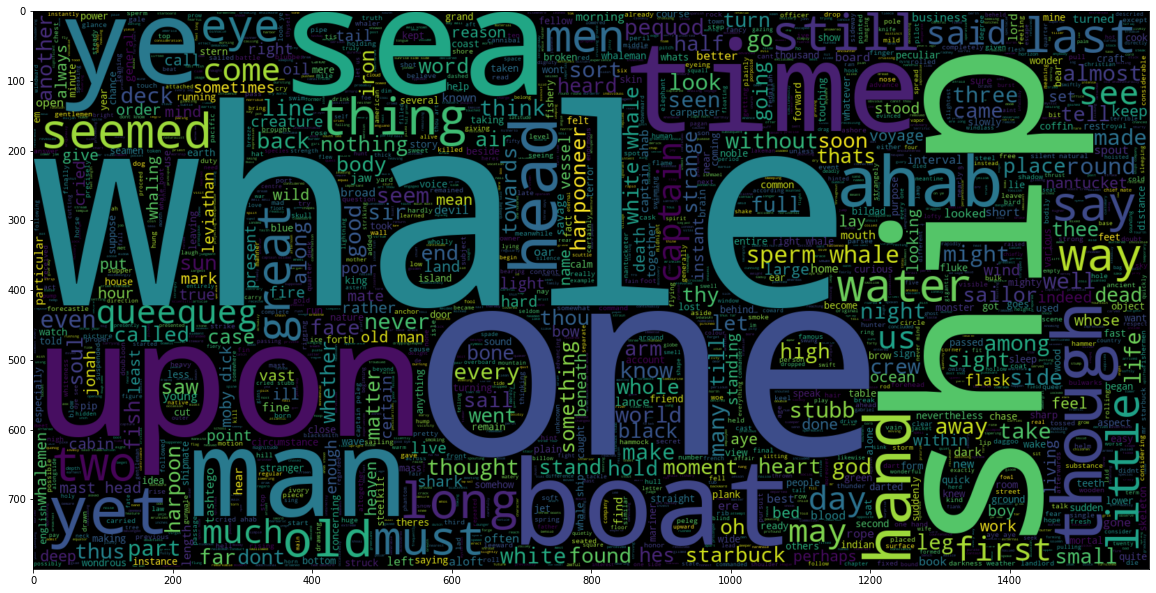

In [6]:
book = ""
for story in df_clean["stories"]:
    book += story
    
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(book)
plt.imshow(wc , interpolation = 'bilinear')

In the wordcloud above, the size of words represent importance and frequency, color represents different classifications. Some of the biggest words are whale, ship, man, time, sea, boat, ahab, water, queequeg, and boat, all related to whale hunting.

### <span style="color:#09429e">Distribution</span> of the frequency of Words

Text(0.5, 1.0, 'Distribution of the frequency of words in chapters.')

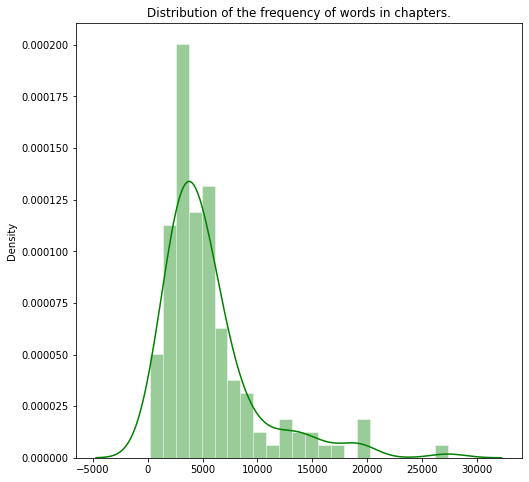

In [7]:
fig, ax = plt.subplots(figsize=(8, 8))
sns.set_style("dark")
sns.distplot([len(x) for x in df_clean["stories"]], ax=ax, color='green')
ax.set_title("Distribution of the frequency of words in chapters.")

Word2Vec only understands individual words, so all chapters are split up into words.

In [8]:
words = [sent.split() for sent in df_clean["stories"]] 
words[0][:10] # First 10 words of chapter 1

['call',
 'ishmael',
 'years',
 'ago',
 'never',
 'mind',
 'long',
 'precisely',
 'little',
 'money']

In [9]:
phrases = Phrases(words, min_count=30, progress_per=10000)
bigram = Phraser(phrases)
sentences = bigram[words]

word_freq = defaultdict(int)
for sent in sentences:
    for i in sent:
        word_freq[i] += 1

print("There are {} different words.".format(len(word_freq)))

There are 16821 different words.


### Top 10 frequent words:

In [10]:
most_freq = sorted(word_freq, key=word_freq.get, reverse=True)[:10]
most_freq

['one', 'whale', 'like', 'upon', 'sea', 'ship', 'ye', 'would', 'man', 'old']

---

# <ins>4.<span style="color:#09429e"> Model</span></ins>

Model created with parameters, no input yet. 

In [11]:
%%time
w2v_model = Word2Vec(min_count=20,
                     window=2,
                     size=1000,
                     sample=6e-5, 
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     negative=20)

CPU times: user 639 µs, sys: 979 µs, total: 1.62 ms
Wall time: 1.29 ms


In [12]:
%%time
w2v_model.build_vocab(words, progress_per=10000)

CPU times: user 296 ms, sys: 9.25 ms, total: 305 ms
Wall time: 307 ms


Training Word2Vec Model

In [13]:
%%time
w2v_model.train(words, total_examples=w2v_model.corpus_count, epochs=30, report_delay=1)

CPU times: user 9.9 s, sys: 59.7 ms, total: 9.96 s
Wall time: 5.34 s


(488612, 3265110)

---

# <ins>5.<span style="color:#09429e"> Exploration</span></ins>

Every word has 1000 vectors.

In [14]:
w2v_model.wv["whale"][:30]

array([-0.09323417, -0.03072614, -0.0681937 , -0.01134596,  0.00216514,
        0.14695936, -0.01938677, -0.03584839,  0.03206102,  0.02874479,
        0.03684483, -0.00939388,  0.04294585,  0.02587145, -0.0616656 ,
       -0.10326264,  0.02174393,  0.04395444, -0.06089798, -0.06131931,
       -0.12683554,  0.03928859, -0.04699203,  0.0345878 , -0.03265394,
        0.08846653,  0.02736439, -0.0213976 ,  0.02599611,  0.05894268],
      dtype=float32)

##### The model tells us that the word whale is similar to sperm, whales, leviathan, fishery, etc.

In [15]:
w2v_model.wv.most_similar(positive=["whale"])

[('sperm', 0.9999469518661499),
 ('whales', 0.9999142289161682),
 ('species', 0.999894380569458),
 ('greenland', 0.9998666048049927),
 ('chapter', 0.9998640418052673),
 ('known', 0.9998605847358704),
 ('fishermen', 0.9998576045036316),
 ('whalemen', 0.9998557567596436),
 ('leviathan', 0.9998507499694824),
 ('fishery', 0.9998500943183899)]

##### On the other hand, whale is not similar to words like dat, thou, ye, sir, thy, which are probably words that described humans.

In [16]:
w2v_model.wv.most_similar(negative=["whale"])

[('dat', -0.9981163740158081),
 ('ye', -0.9984469413757324),
 ('thou', -0.9986104965209961),
 ('de', -0.9986302852630615),
 ('sir', -0.9989813566207886),
 ('aye', -0.9990203380584717),
 ('dont', -0.9990552663803101),
 ('said', -0.9991035461425781),
 ('thy', -0.9991226196289062),
 ('thee', -0.9991307854652405)]

##### The top two words that are similar to captain are Bildad and Peleg, which are the two captains that appear in Moby-Dick.

In [17]:
w2v_model.wv.most_similar(positive=["captain"])

[('peleg', 0.9999451637268066),
 ('want', 0.9999438524246216),
 ('bildad', 0.9999433755874634),
 ('tell', 0.9999428391456604),
 ('aint', 0.999942421913147),
 ('well', 0.9999420046806335),
 ('avast', 0.9999418258666992),
 ('come', 0.999940812587738),
 ('lad', 0.9999401569366455),
 ('think', 0.9999401569366455)]

##### Most similar words of TOP 5 frequent words:

In [18]:
for word in most_freq[:5]:
    print("="*40); print(word)
    print(np.array(w2v_model.wv.most_similar(positive=[word])).reshape(-1,2))

one
[['evinced' '0.9999667406082153']
 ['particular' '0.9999665021896362']
 ['point' '0.9999664425849915']
 ['owing' '0.9999662041664124']
 ['least' '0.9999662041664124']
 ['case' '0.9999660849571228']
 ['often' '0.9999658465385437']
 ['battle' '0.9999656677246094']
 ['generally' '0.9999656081199646']
 ['indeed' '0.9999654293060303']]
whale
[['sperm' '0.9999469518661499']
 ['whales' '0.9999142289161682']
 ['species' '0.999894380569458']
 ['greenland' '0.9998666048049927']
 ['chapter' '0.9998640418052673']
 ['known' '0.9998605847358704']
 ['fishermen' '0.9998576045036316']
 ['whalemen' '0.9998557567596436']
 ['leviathan' '0.9998507499694824']
 ['fishery' '0.9998500943183899']]
like
[['rolling' '0.9999662637710571']
 ['blue' '0.9999660849571228']
 ['dashed' '0.9999654293060303']
 ['air' '0.9999645352363586']
 ['deep' '0.9999643564224243']
 ['thick' '0.99996417760849']
 ['lofty' '0.9999639987945557']
 ['arms' '0.9999639987945557']
 ['tossed' '0.9999638795852661']
 ['swift' '0.999963402748

- whale - leviathan: We can assume that the fishermen feared whales.
- like - dashed, passing, gigantic, red, air, swift: We can expect many dynamic and tense scenes throughout the book.
- upon - almost, large, vast, far: These words tell us there are imminent events.
- sea - rolling, waves, deep, wild: Tells us that the sea was a symbol of mystery and fear.

In [19]:
def average_word_vectors(words, model, vocabulary, num_features):
    feature_vector = np.zeros((num_features, ), dtype = "float64")
    nwords = 0.
    for word in words:
        if word in vocabulary:
            nwords = nwords + 1.
            feature_vector = np.add(feature_vector, model.wv[word])
    if nwords:
        feature_vector = np.divide(feature_vector, nwords)
    return feature_vector
  
    
def averaged_word_vectorizer(corpus, model, num_features):
    vocabulary = set(w2v_model.wv.vocab.keys())
    features = [average_word_vectors(tokenized_sentence, model, vocabulary, num_features) for tokenized_sentence in corpus]
    return np.array(features)

w2v_feature_array = averaged_word_vectorizer(corpus= words, model=w2v_model, num_features=1000)
print("Shape: {}".format(w2v_feature_array.shape))
w2v_feature_array

Shape: (135, 1000)


array([[-0.0957017 , -0.03175565, -0.06561759, ..., -0.0151399 ,
        -0.04567901,  0.07516433],
       [-0.09580156, -0.03187426, -0.06546307, ..., -0.01521032,
        -0.04566649,  0.07509449],
       [-0.09585892, -0.03196794, -0.06531329, ..., -0.01535856,
        -0.04565361,  0.07515035],
       ...,
       [-0.09559339, -0.0318663 , -0.06581308, ..., -0.01503948,
        -0.04567181,  0.07517889],
       [-0.09559926, -0.0317955 , -0.06550774, ..., -0.01522283,
        -0.04569651,  0.07503993],
       [-0.09564257, -0.03185432, -0.06550168, ..., -0.01527571,
        -0.04571122,  0.07497915]])

Previously, each word had a 1000 numbers, a chapter had hundreds of words, and the book had 135 chapters, but this code compressed it so that there are 1000 numbers for each chapter, reuslting in a 135*1000 matrix.

---

# <ins>6.<span style="color:#09429e"> Graphs</span></ins>

### TSNE

In [20]:
rndperm = np.random.permutation(df_clean.shape[0])
def tsnescatterplot(model, word, list_names):
    arrays = np.empty((0, 1000), dtype='f')
    word_labels = [word]
    color_list  = ['red']
    arrays = np.append(arrays, model.wv.__getitem__([word]), axis=0)
    close_words = model.wv.most_similar([word])
    for wrd_score in close_words: # appends vectors
        wrd_vector = model.wv.__getitem__([wrd_score[0]])
        word_labels.append(wrd_score[0])
        color_list.append('blue')
        arrays = np.append(arrays, wrd_vector, axis=0)
    for wrd in list_names: # appends vectors
        wrd_vector = model.wv.__getitem__([wrd])
        word_labels.append(wrd)
        color_list.append('green')
        arrays = np.append(arrays, wrd_vector, axis=0)
    # 1000 -> 50 Dimensions using PCA
    reduc = PCA(n_components=18).fit_transform(arrays)
    np.set_printoptions(suppress=True)
    Y = TSNE(n_components=2, random_state=0, perplexity=15).fit_transform(reduc)
    df = pd.DataFrame({'x': [x for x in Y[:, 0]],
                       'y': [y for y in Y[:, 1]],
                       'words': word_labels,
                       'color': color_list})
    fig, _ = plt.subplots()
    fig.set_size_inches(9, 9)
    
    # Plot
    p1 = sns.regplot(data=df,
                     x="x",
                     y="y",
                     fit_reg=False,
                     marker="o",
                     scatter_kws={'s': 40,
                                  'facecolors': df['color']
                                 }
                    )
    
    for line in range(0, df.shape[0]): # Adding each words
         p1.text(df["x"][line],
                 df['y'][line],
                 '  ' + df["words"][line].title(),
                 horizontalalignment='left',
                 verticalalignment='bottom', size='medium',
                 color=df['color'][line],
                 weight='normal'
                ).set_size(15)

    plt.xlim(Y[:, 0].min()-50, Y[:, 0].max()+50)
    plt.ylim(Y[:, 1].min()-50, Y[:, 1].max()+50)
            
    plt.title('t-SNE visualization for {}'.format(word.title()))

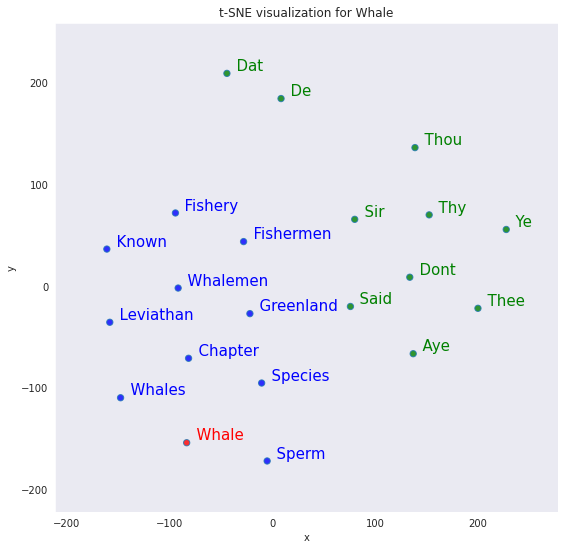

In [21]:
tsnescatterplot(w2v_model, 'whale', [i[0] for i in w2v_model.wv.most_similar(negative=["whale"])])

When the most similar words of whale and most different words from whale are plotted, we can see that similar words are clustered around whale while different ones are distanced.

### Hierarchial Dendrogram

In [22]:
index = list(w2v_model.wv.vocab.keys()) # stores all of the unique words
labels = [title for title in df_clean["title"]] # all titles

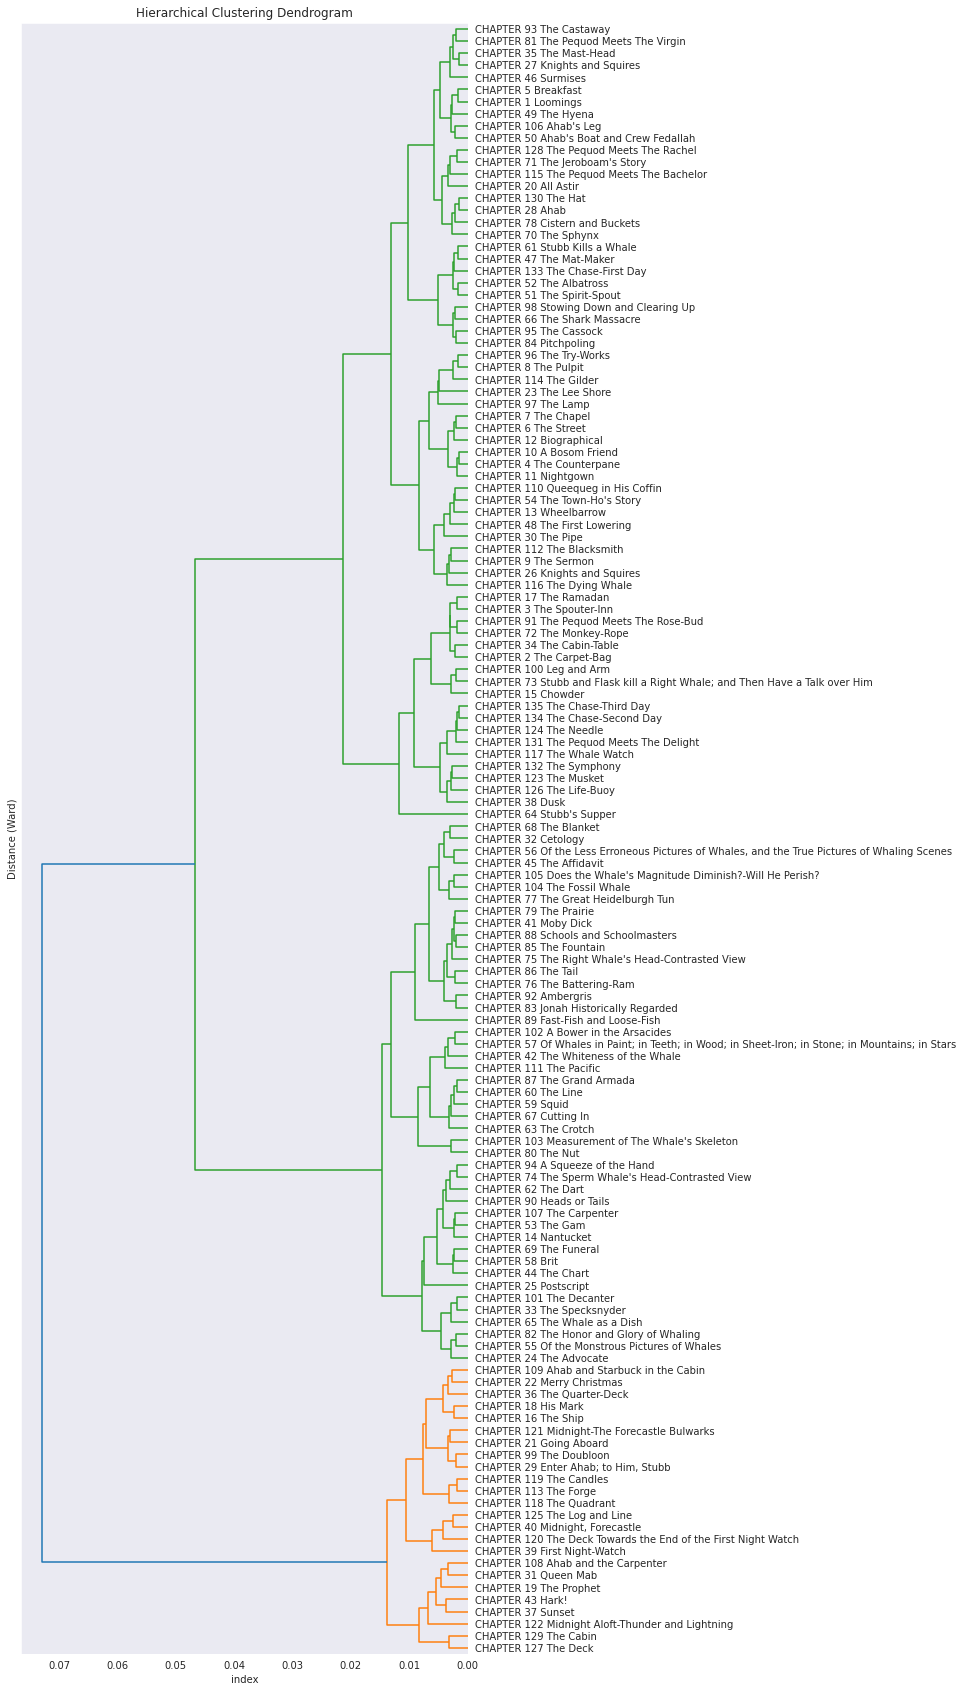

<Figure size 432x288 with 0 Axes>

In [23]:
Z = linkage(w2v_feature_array, 'ward') # reduces to a 135 * 2 matrix
fig, ax = plt.subplots(figsize=(8, 30))
ax = plt.gca()
ax.get_ymajorticklabels()

dd = dendrogram(Z, labels=labels, orientation="left", leaf_font_size=10) 

ax.set_title('Hierarchical Clustering Dendrogram')
ax.set_xlabel('index')
ax.set_ylabel('Distance (Ward)')
plt.show()
plt.savefig("hierarchial_dendrogram.pdf", bbox_inches='tight')

---
# <ins>7.<span style="color:#09429e"> Clustering</span></ins>
##### Emil Schaumburg's Code

In [24]:
!pip install tqdm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [25]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer()
transformed_X = tfidf.fit_transform(df_clean.stories)

In [26]:
from sklearn.cluster import KMeans
from tqdm.auto import tqdm

sum_sqr_dist = []

k_range = range(1,36)
for k in tqdm(k_range):
    modelkmeans = KMeans(n_clusters=k)
    modelkmeans.fit(transformed_X)
    sum_sqr_dist.append(modelkmeans.inertia_)

  0%|          | 0/35 [00:00<?, ?it/s]

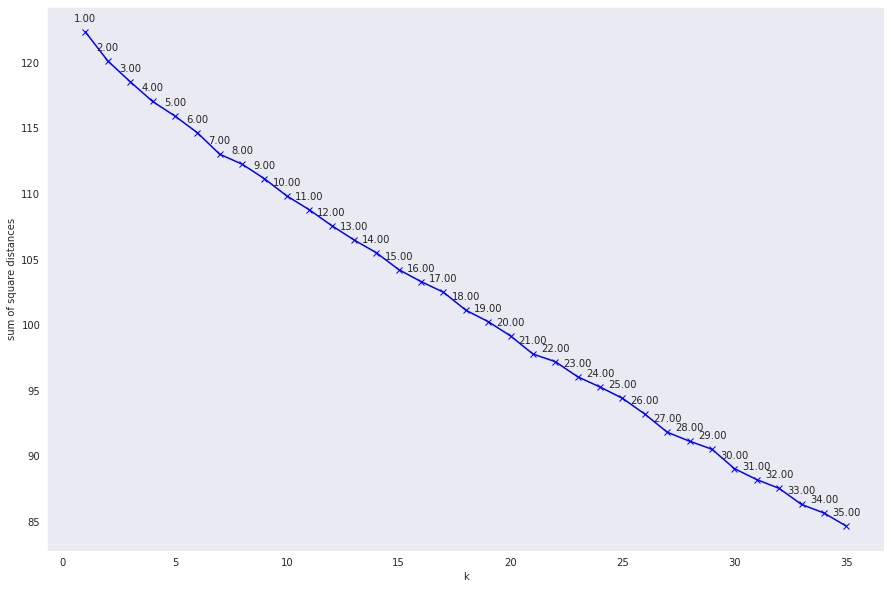

In [27]:
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (15,10)
plt.plot(k_range,sum_sqr_dist,'bx-')
plt.xlabel('k')
plt.ylabel('sum of square distances')
for x,y in zip(k_range,sum_sqr_dist):

    label = "{:.2f}".format(x)

    plt.annotate(label, 
                 (x,y), 
                 textcoords="offset points", 
                 xytext=(0,10), 
                 ha='center') 
plt.show()

In [28]:
import pickle

n_labels=8
finalkmeans = KMeans(n_clusters=n_labels)
finalkmeans.fit(transformed_X)
with open("finalkmeans_mobydick.pkl", "wb") as f:
    pickle.dump(finalkmeans, f)

In [29]:
labels = finalkmeans.fit_predict(transformed_X)
df_clean["labels"] = labels

In [30]:
max_ct = 3
def print_label(label):
    filtered_label = df_clean[labels == label]
    print("Labeled: " + str(label))
    for index, x in filtered_label.sample(max_ct, replace=True).iterrows():
        print(x.title)
        print(x.stories[:300] + "\n")

In [31]:
for i in range(0,n_labels):
    print_label(i)

Labeled: 0
CHAPTER 110 Queequeg in His Coffin
upon searching found casks last struck hold perfectly sound leak must calm weather broke deeper deeper disturbing slumbers huge ground tier butts black midnight sending gigantic moles daylight deep go ancient corroded weedy aspect lowermost puncheons almost looked next mouldy corner stone cask conta

CHAPTER 126 The Life-Buoy
steering south eastward ahabs levelled steel progress solely determined ahabs level log line pequod held path towards equator making long passage unfrequented waters descrying ships ere long sideways impelled unvarying trade winds waves monotonously mild seemed strange calm things preluding riotous 

CHAPTER 126 The Life-Buoy
steering south eastward ahabs levelled steel progress solely determined ahabs level log line pequod held path towards equator making long passage unfrequented waters descrying ships ere long sideways impelled unvarying trade winds waves monotonously mild seemed strange calm things preluding riotou

In [32]:
for i in range(0, n_labels):
    print(f"Labeled {i}")
    print(df_clean.loc[df_clean["labels"] == i]["title"][:5])

Labeled 0
109    CHAPTER 110 Queequeg in His Coffin
111            CHAPTER 112 The Blacksmith
125             CHAPTER 126 The Life-Buoy
Name: title, dtype: object
Labeled 1
18            CHAPTER 19 The Prophet
20           CHAPTER 21 Going Aboard
25    CHAPTER 26 Knights and Squires
29               CHAPTER 30 The Pipe
30              CHAPTER 31 Queen Mab
Name: title, dtype: object
Labeled 2
0          CHAPTER 1 Loomings
6        CHAPTER 7 The Chapel
13       CHAPTER 14 Nantucket
23    CHAPTER 24 The Advocate
24      CHAPTER 25 Postscript
Name: title, dtype: object
Labeled 3
1     CHAPTER 2 The Carpet-Bag
2    CHAPTER 3 The Spouter-Inn
3    CHAPTER 4 The Counterpane
4          CHAPTER 5 Breakfast
5         CHAPTER 6 The Street
Name: title, dtype: object
Labeled 4
15           CHAPTER 16 The Ship
17           CHAPTER 18 His Mark
19          CHAPTER 20 All Astir
21    CHAPTER 22 Merry Christmas
Name: title, dtype: object
Labeled 5
27                  CHAPTER 28 Ahab
33       CHAPTER 34 T

# <ins>8.<span style="color:#09429e"> Conclusion</span></ins>

> - The Hierarchial dendrogram clusters chapters based on similarity. Chapter 1 and 49 are clustered together, and those chapters both talk about Ishmael going to sea. Also, the last two chapters(Chapter 134 and 135) are clustered together, which makes sense because they have similar titles (The Chase-Second Day and The Chase-Third Day) and are both about the endings of Moby-Dick. 
> - The K means Clustering method categorized the chapters into 8 clusters, and the clusters are similar to the hierarchial dendrogram's clusters in general. 
> - Since computers can not read and interpret arrays of words and due to my lack of understanding of more advanced techniques, I could not get a nice summary of the book, but I could discover relationships between characters, chapters, the most frequent terms, and the general atmosphere of the book.

---

## References/Credits:
- About Moby-Dick: ([https://www.shmoop.com/study-guides/literature/moby-dick](http://))
- Moby-Dick full book: https://www.gutenberg.org/files/2701/2701-h/2701-h.htm
- 레안드로 로저's work about Poe's short stories
- 피에르 메그렛's tutorial of Gensim
- 마다브 마투르's work about sarcasm detection